## 1 Latent Dirichlet Allocation [60pts]

In this problem, we will use Latent Dirichlet Allocation to perform topic modeling on Amazon Review datasets. In particular, we will take an in-depth look at different aspects of LDA model.


In [7]:
%pip install gensim
# install gensim for LDA
%pip install nltk 
# install nltk to preprocess sentences
%pip install pyldavis
# to visualize LDA topics
%pip install matplotlib 
# for plotting

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.



The cell below tests if the packages we need have been installed correctly, and that we are in the correct environment.

In [8]:
import gensim
import nltk
nltk.download("stopwords")
import pyLDAvis
import matplotlib
%matplotlib inline
import gzip # to unzip the data
import re # to replace punctuations
from nltk.corpus import stopwords # list of stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JESIHNTHA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1.2 Datasets

You can download the Amazon reviews dataset of Cellphones & Accessory 5-Core Data [here](http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Cell_Phones_and_Accessories_5.json.gz). Place the downloaded dataset in the same folder as this notebook. You can use the following code to read a datat from GZIp file

In [3]:
# A function to read the zipped data at a specfic path
#
# How to use:
# PATH = "/path/to/file"
# for line in parse(PATH):
#   do something with line
#
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

## 1.3 Data Cleaning

Now we will preprocess the data using the following steps:
   1. Remove stopwords
   2. Lower-case all words
   3. Remove words with less than 2 characters
   4. Remove punctuation
   5. Split each sentence into a list of words

In [4]:
# A function to clean a single line of text
def clean_line(line):
    """ Clean stopwords and punction for each line
    
    Args: 
        line (string): one line in file
        
    Returns:
        list(str): a list of all words in the sentence
    """
    punctuationRegex = r'\W+|\d+'
    stopWords = set(stopwords.words('english'))
    line = line.split(" ")
    filtered_content = []
    for word in line:
        word = word.lower()
        clean_word = re.sub(pattern =punctuationRegex,repl='',string=word)
        if clean_word not in stopWords and len(clean_word)>=2 and clean_word != '':
                    filtered_content.append(clean_word)
    return filtered_content

In [5]:
stopWords = set(stopwords.words('english'))

In [7]:
# stopWords

Finally, we put parse() and clean_line() function together and then extract the first 10,000 reviews into a new text file as your experiment dataset

In [5]:
def read_dataset(fname):
    """ Read the 10000 lines in given dataset into list and clean stop words. 
        
    Args: 
        fname (string): filename of Amazon Review Dataset
        
    Returns:
        list of list of words: we view each document as a list, including a list of all words 
    """
    count = 0
    exp_dataset = []
    for review in parse(fname):
        line = review["reviewText"]
        new_line = clean_line(line)
        exp_dataset.append(new_line)
        count += 1
        if count > 10000:
            break
    return exp_dataset

In [6]:
%%time
r = read_dataset("reviews_Cell_Phones_and_Accessories_5.json.gz")

CPU times: user 1.91 s, sys: 97.6 ms, total: 2.01 s
Wall time: 2.01 s


In [7]:
len(r)

10001

In [8]:
r

[['look',
  'good',
  'stick',
  'good',
  'dont',
  'like',
  'rounded',
  'shape',
  'always',
  'bumping',
  'siri',
  'kept',
  'popping',
  'irritating',
  'wont',
  'buy',
  'product',
  'like'],
 ['stickers',
  'work',
  'like',
  'review',
  'says',
  'stick',
  'great',
  'stay',
  'phone',
  'super',
  'stylish',
  'share',
  'sister'],
 ['awesome',
  'make',
  'phone',
  'look',
  'stylish',
  'used',
  'one',
  'far',
  'almost',
  'year',
  'believe',
  'one',
  'year',
  'great',
  'quality'],
 ['item',
  'arrived',
  'great',
  'time',
  'perfect',
  'condition',
  'however',
  'ordered',
  'buttons',
  'great',
  'deal',
  'included',
  'free',
  'screen',
  'protector',
  'never',
  'received',
  'one',
  'though',
  'big',
  'deal',
  'wouldve',
  'nice',
  'get',
  'since',
  'claim',
  'comes',
  'one'],
 ['awesome',
  'stays',
  'looks',
  'great',
  'used',
  'multiple',
  'apple',
  'products',
  'especially',
  'nails',
  'helps',
  'elevated',
  'key'],
 ['make

## 1.4 Topic Analysis

**[5pts] Q1.4.1.1** Use topic numbers 3, 6, 9, 12, 15 respectively and print out all topics with 5 words.

For this We will use gensim to train an LDA model. gensim requires the following steps:

Construct a gensim.corpora.dictionary from the dataset
Construct a gensim "corpus" using this dictionary, by mapping each word to an index in the dictionary
Run LDA on this corpus

In [9]:
# ! python -m spacy download en_core_web_lg

In [10]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel


import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [11]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [12]:
%%time
data_lemmatized = lemmatization(r, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

CPU times: user 34.3 s, sys: 141 ms, total: 34.5 s
Wall time: 34.5 s


In [13]:
dictionary = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized

corpus = [dictionary.doc2bow(text) for text in texts]

The function below prints the top num words in each topic for a given model.

In [151]:
def print_topic_words(model,num):
    for topic_idx in range(model.num_topics):
        topic_words = model.show_topic(topic_idx, topn=num)
        print(", ".join([word for word, prob in topic_words]))
    print('\n')
    return

The following function builds multiple LDA models with number of topics specified in the list `num_topics`.

In [15]:
def build_num_topic_model(dictionary, corpus, num_topics):

    for num_topic in num_topics:
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topic, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        
        
        print_topic_words(lda_model,5)
        

In [16]:
build_num_topic_model(dictionary, corpus, [3, 6, 9, 12, 15])

screen, phone, camera, protector, signal
use, iphone, case, phone, work
battery, juice, pack, mophie, charge


annoying, gs, touch, item, talk
use, phone, pack, work, get
battery, juice, charge, cable, plug
screen, phone, however, rather, round
iphone, case, mophie, s, pocket
regularly, plantronic, seller, decent, claim


annoying, gs, talk, plastic, deal
use, phone, get, well, great
battery, work, juice, charge, cable
pack, screen, however, finish, indicator
iphone, case, mophie, fit, pocket
rather, trade, read, datum, card
headset, sound, ear, quality, chore
call, signal, cell, application, expensive
increase, hear, lead, normally, device


difficult, lead, annoying, nice, normally
use, phone, get, well, good
battery, life, double, probably, part
screen, however, round, matte, camera
iphone, case, mophie, pocket, bottom
indicator, state, limit, error, addition
work, juice, charge, extra, plug
cell, expensive, version, value, unfortunately
pack, s, cable, device, type
call, rather, ob

**[3pts] Q1.4.1.2**  Explain what could be interpreted for each topics, and describe the similarity and difference between different topic numbers.

- The topics identified by the LDA models seem to be related to different aspects of phones and phone usage, such as phone features, accessories, and functions. As the number of sub-topics increases, the topics become more specific and detailed.

- For example ,the first topic might related to issues people have with their phone batteries; The Third topic might be about phone use and performance, with words like "phone," "well," "good," "use," and "get." It could relate to how people use their phones and what they can do to improve their experience or address any issues they are experiencing.

**[2pts] Q1.4.1.3**  Which topic number would you choose? Explain.

- I believe choosing 9 as the number of topics would strike a good balance between complexity and interpretability. With 9 topics, the model is not overly simplistic, yet the topics are still easy to interpret. In contrast, topic numbers 3 and 6 provide less detail, while topic numbers 12 and 15 may have overlapping topics, making them more difficult to distinguish. 

## 1.5 Model Evaluation

**[12 pts] Q1.5.1** Now we investigate two methods to evaluate our model and choose the topic number

1.Perplexity is a measurement of how well a probability distribution or probability model predicts a sample. A low perplexity indicates the probability distribution is good at predicting the sample. We can use model.log_perplexity(document) to evaluate the perplexity of our LDA model.

2.Topic coherence is a one type of interpretability measurement for a topic. It measures if a set of top keywords describe a coherent and singular concept. A good topic will have high topic coherence score. We can use CoherenceModel(model=ldamodel).get_coherence() to calculate it.

Plot Perplexity and topic coherence scores of our LDA model for topic number 3,6,9,12,15,20,50.

The code below trains topic models with different numbers of topics and measures their coherence and perplexity.

In [17]:
# perplexity 
# run different number of topics to get perplexity and coherence value for this model
from gensim.models.coherencemodel import CoherenceModel
def get_measurement_for_model(dictionary, corpus, topic_nums):
    """ Build lda model with given parameters 
    
    Args: 
        dictionary: dictionary built from dataset
        corpus: corpus built from dataset
        topic_nums: a list contains all possible topic number
        
    Returns:
        2 lists: one of perplexities, and one of coherence value
    """  
    perplexity = []
    coherence_value=[]
    
    for num_topic in topic_nums:
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                   id2word=dictionary,
                                   num_topics=num_topic, 
                                   random_state=100,
                                   update_every=1,
                                   chunksize=100,
                                   passes=10,
                                   alpha='auto',
                                   per_word_topics=True)
        perplex = lda_model.log_perplexity(corpus)
        perplexity.append(perplex)
        coherence = CoherenceModel(model=lda_model,texts=texts, dictionary=dictionary).get_coherence()
        coherence_value.append(coherence)
    
    return perplexity,coherence_value

In [18]:
perplexity, coherence = get_measurement_for_model(dictionary, corpus, [3, 6, 9, 12, 15, 20, 50])

In [19]:
print(perplexity)
print('\n')
print(coherence)

[-7.495355330991471, -7.630259357251497, -7.836523810410719, -8.642289677371691, -11.715339669259313, -15.646725346975659, -27.106593050087643]


[0.443733478746837, 0.3480471918185008, 0.3168135996403625, 0.33036151983115236, 0.31369638069426947, 0.26573563785491144, 0.3531855327489765]


We can now plot the coherence and perplexity of each model.

In [20]:
import matplotlib.pyplot as plt

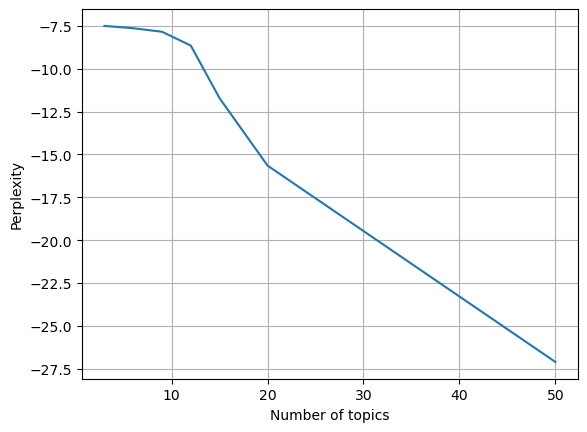

In [21]:
plt.plot([3, 6, 9, 12, 15, 20, 50], perplexity)
plt.grid()
plt.xlabel("Number of topics")
plt.ylabel("Perplexity")
plt.show()

**[2pts] Q1.5.2**  From the above graph what topic number would you choose and why? Is it a good idea to choose the topic number based on perplexity? why or why not?

- I would choose a topic number of 50, as the log_perplexity continues to decrease with an increasing number of topics, indicating that the model improves with more topics. I would choose Perplexity as one of the measurement, and we need to combine with other measurement, since there is a possibility that perplexity can continue to decrease while too many topics make interpretation difficult.

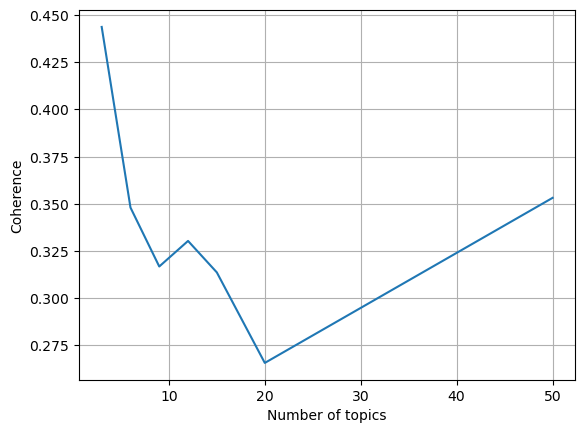

In [22]:
plt.plot([3, 6, 9, 12, 15, 20, 50], coherence)
plt.grid()
plt.xlabel("Number of topics")
plt.ylabel("Coherence")
plt.show()

**[2pts] Q1.5.3**  From the above graph what topic number would you choose and why?

-  I would choose a topic number of 3 because it has the highest coherence score, indicating that the model performs better compared to other topic numbers.


**[4pts]Q1.5.4** Compare two methods you implemented in the previous quesions, which one do you think is better and why? In answering, please discuss the actual topics generated.

- I prefer topic number 50 due to its high coherence score and low log perplexity score. While there is some overlap between topics, the words within each topic are coherent and easy to interpret. For instance, topic 5 contain word like cool and pretty to describe the device.

In [23]:
build_num_topic_model(dictionary, corpus, [50])

remove, hear, never, people, actually
iphone, look, day, wife, glad
s, want, place, stay, show
love, experience, spend, suppose, insert
different, design, pretty, quite, cool
unit, test, high, check, idea
car, lead, touch, light, blue
fast, person, highwayprice, headsetshort, gramsthree
extra, live, factory, headsetoveralloverall, headsetshort
call, purchase, one, receive, install
headsetssound, highwayprice, headsetoveralloverall, headsetshort, chargescon
great, buy, price, review, cheap
problem, complain, wall, direct, headsetssound
able, picture, early, page, description
headsetssound, highwayprice, headsetoveralloverall, headsetshort, chargescon
come, almost, driving, headsetssound, highwayprice
really, convenient, switch, sometimes, guess
need, start, ad, highwayprice, headsetshort
finish, year, wait, perform, abuse
little, take, fall, shipping, worry
phone, new, thank, many, replacement
headsetssound, highwayprice, headsetoveralloverall, headsetshort, chargescon
headsetssound, hi

## 1.6 Alpha and Beta in LDA

**[7pts]Q1.6.1** In this problem, we will check the two most important parameters in LDA model: alpha and beta. Alpha represents document-topic density - with a higher alpha, documents are made up of more topics, and with lower alpha, documents contain fewer topics. Beta represents topic-word density - with a high beta, topics are made up of most of the words in the corpus, and with a low beta they consist of few words.

In [24]:
best_topic_num =50  # CHANGE THIS

In [25]:
#model 1
model1 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                           id2word=dictionary,
                           num_topics=best_topic_num, 
                           random_state=100,
                           update_every=1,
                           chunksize=100,
                           passes=10,
                           alpha=(1/best_topic_num),
                           eta = (1/best_topic_num),
                           per_word_topics=True)  
print_topic_words(model1,10)


even, remove, hear, people, actually, never, let, yet, leave, change
iphone, use, wife, glad, gs, old, back, day, full, return
s, want, stay, place, show, adapter, disappointed, ipad, laterbattery, manualcomfort
love, experience, spend, money, suppose, insert, boost, advertise, well, future
wear, pretty, quite, design, different, cool, effect, jack, sweet, headsetssound
last, unit, long, seem, high, check, test, idea, current, pass
car, lead, touch, light, nice, blue, profile, highwayprice, headsetssound, oncepaire
recommend, fast, person, laterbattery, headsetssound, headsetoveralloverall, largewall, headsetshort, cerisecharging, highwayprice
extra, live, factory, headsetoveralloverall, headsetshort, headsetssound, highwayprice, largewall, chargescon, laterbattery
call, purchase, one, receive, install, miss, worth, wonder, spot, crazy
chargescon, boxan, laterbattery, largewall, highwayprice, headsetssound, headsetshort, headsetoveralloverall, gramsthree, manualproslook
work, buy, grea

In [26]:
#model 2
model2 =gensim.models.ldamodel.LdaModel(corpus=corpus,
                           id2word=dictionary,
                           num_topics=best_topic_num, 
                           random_state=100,
                           update_every=1,
                           chunksize=100,
                           passes=10,
                           alpha=1/2,
                           eta =1/5,
                           per_word_topics=True)

print_topic_words(model2,10)

battery, phone, use, life, increase, need, home, available, s, rather
headset, sound, ear, use, quality, well, hear, good, call, noise
effectly, unavoidably, slimmer, encumber, chore, packageoverall, shed, ibooster, voyagerpro, hopeful
screen, protector, cloth, digitizer, crystal, glossy, sensitivity, sticker, flawless, mix
effectly, unavoidably, slimmer, encumber, chore, packageoverall, shed, ibooster, voyagerpro, hopeful
effectly, unavoidably, slimmer, encumber, chore, packageoverall, shed, ibooster, voyagerpro, hopeful
effectly, unavoidably, slimmer, encumber, chore, packageoverall, shed, ibooster, voyagerpro, hopeful
effectly, unavoidably, slimmer, encumber, chore, packageoverall, shed, ibooster, voyagerpro, hopeful
effectly, unavoidably, slimmer, encumber, chore, packageoverall, shed, ibooster, voyagerpro, hopeful
effectly, unavoidably, slimmer, encumber, chore, packageoverall, shed, ibooster, voyagerpro, hopeful
effectly, unavoidably, slimmer, encumber, chore, packageoverall, she

In [27]:
#model 3
model3 =gensim.models.ldamodel.LdaModel(corpus=corpus,
                           id2word=dictionary,
                           num_topics=best_topic_num, 
                           random_state=100,
                           update_every=1,
                           chunksize=100,
                           passes=10,
                           alpha='auto',
                           eta ='auto',
                           per_word_topics=True)

print_topic_words(model3,10)

remove, hear, never, people, actually, let, yet, internet, happen, black
iphone, look, day, wife, glad, seem, gs, back, last, old
s, want, place, stay, show, adapter, disappointed, ipad, laterbattery, manualcomfort
love, experience, spend, suppose, insert, boost, advertise, future, headsetoveralloverall, headsetssound
different, design, pretty, quite, cool, effect, jack, sweet, headsetssound, laterbattery
unit, test, high, check, idea, current, pass, output, testing, highwayprice
car, lead, touch, light, blue, profile, largewall, ougoing, highwayprice, headsetshort
fast, person, gramsthree, cerisecharging, laterbattery, largewall, highwayprice, headsetssound, headsetshort, headsetoveralloverall
extra, live, factory, headsetoveralloverall, headsetshort, headsetssound, highwayprice, largewall, chargescon, laterbattery
call, purchase, one, receive, install, believe, miss, wonder, crazy, bear
chargescon, boxan, laterbattery, largewall, highwayprice, headsetssound, headsetshort, headsetover

**[3pts]1.6.2**  Explain how the different alpha and beta values theoretically influence the LDA model. Then describe what you find in the empirical result (e.g difference in topic words and topics)

- The alpha value in a topic model influences the diversity of topics in documents, with a larger alpha promoting a more diverse set of topics, and a smaller alpha resulting in fewer dominant topics. The beta value, on the other hand, affects the diversity of words in topics, with a larger beta promoting a diverse set of words, and a smaller beta resulting in fewer dominant words. 
- Based on my empirical analysis, the output of model1 and model3 shows similarities. However, model2 has larger values of alpha and beta, causing the output to focus on fewer topics, resulting in multiple topics containing the same words.


## 1.7 LDA on a short text dataset

**[10pts]1.7.1** In this part, we will read a dataset from twitter and build a LDA model. On Windows, download and unzip the dataset from [this link](http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip). Place the downloaded dataset in the same folder as this notebook. Use the first 10,000 lines in the "training.1600000.processed.noemoticon.csv" file. 

In [28]:
# !wget http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip # Linux and OSX only
# !unzip trainingandtestdata.zip # Linux and OSX only

In [29]:
!head -n 10000 training.1600000.processed.noemoticon.csv > twitter.csv # Linux and OSX only

In [30]:
def read_twitter(fname):
    """ Read the given dataset into list and clean stop words. 
    
    Args: 
        fname (string): filename of Twitter Dataset
        
    Returns:
        list of list of words: we view each document as a list, including a list of all words 
    """
    twitter = []
    with open(fname, encoding="utf-8") as f:
        for line in f:  
            tweet = line.split(",")[5]
            new_line = clean_line(tweet)
            twitter.append(new_line)
    return twitter

In [31]:
%%time
twitter = read_twitter('twitter.csv')

CPU times: user 673 ms, sys: 72.5 ms, total: 746 ms
Wall time: 751 ms


In [33]:
%%time
data_lemmatized_2 = lemmatization(twitter, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

CPU times: user 11.7 s, sys: 79.6 ms, total: 11.8 s
Wall time: 11.8 s


In [34]:
twitter_dictionary = corpora.Dictionary(data_lemmatized_2)
texts_2 = data_lemmatized_2
twitter_corpus = [twitter_dictionary.doc2bow(text) for text in texts_2]

## 1.8 LDA visualization

**[10pts]1.8.1** We will now visualize the LDA output using pyLDAvis. PyLDAVis shows the following:

   1. The distances between topics, as a map in 2-D space.
   2. The variance in the topic-word distribution, as the size of a circle in this map.
   3. The most "salient" terms in each topic.

In [36]:
%%time
# !pip install pyLDAvis
# !conda install -c conda-forge pyldavis


CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 3.1 µs


In [37]:
import pyLDAvis.gensim_models
from gensim.models.ldamodel import LdaModel

In [38]:
lda_model_ = LdaModel(corpus=twitter_corpus, id2word=twitter_dictionary, num_topics=10)

In [39]:
%%time
data = pyLDAvis.gensim_models.prepare(lda_model_, twitter_corpus, twitter_dictionary)

/Users/peiqichen/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/peiqichen/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/peiqichen/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/peiqichen/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/peiqichen/opt/anac

CPU times: user 743 ms, sys: 165 ms, total: 909 ms
Wall time: 3.12 s


In [40]:
pyLDAvis.enable_notebook()
pyLDAvis.display(data)

# 2.word2Vec [40pts]


In this problem, we use Amazon Review Dataset to perform Word2Vec and Doc2Vec to extract insights relevant for e-commerce business. For this question, download and use the dataset [here](http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Electronics_5.json.gz||reviews_Electronics_5.json.gz).

## 2.1 Data Cleaning



The following code reads the data from a GZIP file.

In [1]:
# A function to read the zipped data at a specfic path
#
# How to use:
# PATH = "/path/to/file"
# for line in parse(PATH):
#   do something with line
#
import gzip
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

We will now read the data and preprocess it using the following steps:

   1. Remove stopwords
   2. Lower-case all words
   3. Remove words with less than 2 characters
   4. Remove punctuation
   5. Split each sentence into a list of words

   And finally extract 10000 reviews.

In [2]:
def clean_line(line):
    """ Clean stopwords and punction for each line
    
    Args: 
        line (string): one line in file
        
    Returns:
        list(str): a list of all words in the sentence
    """
    punctuationRegex = r'\W+|\d+'
    stopWords = set(stopwords.words('english'))
    line = line.split(" ")
    filtered_content = []
    for word in line:
        word = word.lower()
        clean_word = re.sub(pattern =punctuationRegex,repl='',string=word)
        if clean_word not in stopWords and len(clean_word)>=2 and clean_word != '':
                    filtered_content.append(clean_word)
    return filtered_content

def read_dataset(fname):
    """ Read the 100000 lines in given dataset into list and clean stop words. 
        
    Args: 
        fname (string): filename of Amazon Review Dataset
        
    Returns:
        list of list of words: we view each document as a list, including a list of all words 
    """
    count = 0
    exp_dataset = []
    for review in parse(fname):
        line = review["reviewText"]
        new_line = clean_line(line)
        exp_dataset.append(new_line)
        count += 1
        if count > 100000:
            break
    return exp_dataset    

In [9]:
%%time
r = read_dataset('C:/Users/JESIHNTHA/Desktop/HW3/reviews_Electronics_5 (1).json.gz')

CPU times: total: 46.5 s
Wall time: 47.4 s


In [44]:
len(r)

100001

## 2.2 Build a doc2vec model

**[3pts]2.2.1** In this question, first we will build a Word2Vec model using ginsim using size=300, min_count=40, win- dow=10, negative=10, max_vocab_size=10000. Train the model for 30 epochs.

In [10]:
from gensim.models import Word2Vec
model = Word2Vec(r, vector_size=300, min_count=40, window=10, negative=10, max_vocab_size=10000, epochs=30)


**[2pts]2.2.2** Use model.wv.doesnt_match to find a word in ["Canon","Nikon","junk"] that does not

belong.

In [11]:
# YOUR CODE HERE ["Canon", "Nikon", "junk"]
model.wv.doesnt_match( ["Canon","Nikon","junk"]  )

'junk'

**[3pts]2.2.3** Come up with 3 other word lists and apply the above function. Explain your observation.

In [23]:
# write your code here
wordlist1 = ['smartphone','tablet','desktop']
wordlist2 = ['keyboard','headphones','camera']
wordlist3 = ['speaker','amplifier','projector']

print("The word that doesnt match in 'smartphone','tablet','desktop' is :", model.wv.doesnt_match( wordlist1 ))
print("The word that doesnt match in 'keyboard','headphones','camera' is :",  model.wv.doesnt_match( wordlist2 ))
print("The word that doesnt match in 'speaker','amplifier','projector' is:", model.wv.doesnt_match( wordlist3 ))


The word that doesnt match in 'smartphone','tablet','desktop' is : desktop
The word that doesnt match in 'keyboard','headphones','camera' is : camera
The word that doesnt match in 'speaker','amplifier','projector' is: projector


- model.wv.doesnt_match is finding the word that is least related to the other words in the list. 

**[2pts]2.2.4** What are some tasks in e-commerce that can be solved with this simple function?

-  Product recommendations can be improved by using the Word2Vec model to avoid recommending products that are unrelated

## 2.3 Build a doc2vec model

**[15 pts] 2.3.1**  Each review is marked by other customers as “helpful” or not. The "helpful: [a, b]" item in each review is (a) the number of people who marked the review as helpful, and (b) the total number of people who have marked the review as helpful or unhelpful. The "helpfulness" score of a review can be calculated as a/b. Define a "helpful" review as one with helpfulness score >= 0.8. Given a review that is only slightly helpful, could we find textually similar reviews but have higher helpfulness? Build Doc2Vec model with gensim on review data. Use product ID “B00006I5WJ” and ReviewerID with “A14453U0KFWF31” as an example, find top 5 helpful reviews of the same product with similarity score above 0.8. 

In [24]:
import os
def read_reviewers_data(fname, min_count=0):
    '''
    Save all reviews into their own product asin files.
    Make sure you have 'product' folder when you run this answer.
    In each file, you can choose your own log structure. In this answer, log strucutre is like 
        "reviewText"\t"reviewerID"\t"helpful"
    Args: 
        fname: dataset file path
        min_count: minimum number of reviews of a product
    Returns:
        none
    '''
    if not os.path.isdir('product'):
        os.makedirs('product')
    asin_list = []
    tmp_list = []
    last_asin = ""
    j = 0
    for i in parse(fname):
        if last_asin != i['asin']:
            if len(tmp_list) > min_count:
                f = open("product/" + last_asin+".txt", 'w')
                for one in tmp_list:
                    f.write(one)
                f.close()
            tmp_list = []
            last_asin = i['asin']
        tmp_list.append(i["reviewText"] + '\t' + i["reviewerID"] +
                    '\t' + handle_helpful(i["helpful"]) + "\n")
        j += 1
        if j > 100000:
            break
            
def handle_helpful(helpful):
    '''
    Helper function for helpful_score calculate
    Args: 
        helpful: list. The first element is the number of people think this is helpful. The second element
            is the total number of people evaluate this comment
    Returns:
        String: number represent helpfulness
    '''
    if helpful[1] != 0:
        helpfulness = 1.0 * helpful[0] / helpful[1]
        return str(helpfulness)
    else:
        return str(0)

In [25]:
read_reviewers_data('C:/Users/JESIHNTHA/Desktop/HW3/reviews_Electronics_5 (1).json.gz')

In [26]:
class TaggedReviewDocument(object):
    '''
    This class could save all products and review information in its dictionary and generate iter for TaggedDocument
        which could used for Doc2Vec model
    '''
    def __init__(self, dirname):
        self.dirname = dirname
        self.helpfulness = {}  # key:reviewerID value:helpfulness
        self.product = {}      # key:asin value:reviewerID
        self.asin = []

    def __iter__(self):
        for filename in os.listdir(self.dirname):
            asin_code = filename[:-4] #delete ".txt"
            self.product[asin_code] = []
            self.asin.append(asin_code)
            for line in enumerate(open(self.dirname + "/" + filename)):
                line_content = line[1].split("\t")
                self.product[asin_code].append(line_content[1])
                self.helpfulness[line_content[1]] = float(line_content[2])
                yield TaggedDocument(clean_line(line_content[0]), [line_content[1], line_content[2]])


In [27]:
documents = TaggedReviewDocument("product")

In [28]:
%%time
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
model = Doc2Vec(documents, vector_size=50, window=10, min_count=5, workers=4, epochs=10)


CPU times: total: 12min 32s
Wall time: 11min 29s


## Find similar reviews

In [29]:
from sklearn.metrics.pairwise import cosine_similarity

def find_similar_reviews(asin, reviewer_id):
    '''
    If one review is similar to the specific review and it is much helpful, save it to a list
    Args: 
        asin: product asin
        reviewer_id: the specific review
    Returns:
        list of reviewer text sorted by similarity score in descending order
    '''
    with open(f"product/{asin}.txt", "r") as f:
        for line in f:
            fields = line.strip().split("\t")
            if fields[1] == reviewer_id:
                query_review_text = fields[0]
    query_vector = model.infer_vector(query_review_text.split()) 
      
    result = []
    with open(f"product/{asin}.txt", "r") as f:
        for line in f:  
            fields = line.strip().split("\t")
            if fields[1] != reviewer_id:
                review_text = fields[0]
                review_vector = model.infer_vector(review_text.split()) 
                similarity_score = cosine_similarity(query_vector.reshape(1, -1), review_vector.reshape(1, -1))[0][0]
                review_helpfulness = float(fields[2])
                if similarity_score > 0.8 and review_helpfulness >= 0.8:
                    result.append((review_text, similarity_score))
                    
    result = sorted(result, key=lambda x: x[1], reverse=True)
    result = [x[0] for x in result]
    
    if len(result) < 5:
        return result [0:len(result)]
    else:
        return result


In [30]:
print(find_similar_reviews("B00006I5WJ", "A14453U0KFWF31")) 

["Quite simply, the Model One is a good little table radio.  It won't wash your clothes or even play a CD, but it does one thing and does it very well.Perhaps more important than the sound, the Model One has a very nice FM tuner.  Reception is superb (Better than anything I have seen without a large antenna), and the tuner is very accurate, so you can easily tune in on as station as best as possible.The sound is good for something so small:  quite full, and no major flaws for such a small unit, although it does sound unspectacular by any means when compared with a full sized stereo, it was never meant to compete with that.If you are looking for a little radio for the bathroom, home office, or kitchen (It'd even be a fine addition to the office at work, if some soft music is acceptable), or anywhere else you might want the addition of some music without a hassle, the Model One is a nice little radio, and I'd strongly reccomend it.", "The TIVOLI MODEL 1 is one fine-sounding little radio!

## 2.4 Build a doc2vec model using product descriptions


**[10pts]2.4.1** Use product descriptions (located in meta data  [here](http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/meta_Electronics.json.gz)) to build a Doc2Vec model. When building the doc2vec model, use vector_size=100, window=15, min_count=5, max_vocab_size=1000, and train it for 1 epoch.

In [31]:
def read_product_description(fname):
    '''
    Load all product descriptions
    Args: 
        fname: dataset file path
    Returns:
        dict: key is asin, value is description content
    '''
    result = {}
    for i in parse(fname):
        try:
            if "Camera & Photo" in i["categories"][0]:
                result[i["asin"]]=i["description"]
        except:
            continue
    return result

In [32]:
class TaggedDescriptionDocument(object):
    '''
    This class could save all products and review information in its dictionary and generate iter for TaggedDocument
        which could used for Doc2Vec model
    '''
    def __init__(self, descriptondict):
        self.descriptondict = descriptondict
        

    def __iter__(self):
        for asin in self.descriptondict:
            for content in self.descriptondict[asin]:
                yield TaggedDocument(clean_line(content), [asin])


In [33]:
description_dict = read_product_description("meta_Electronics.json.gz")
des_documents = TaggedDescriptionDocument(description_dict)

In [ ]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
model_d = Doc2Vec(des_documents, vector_size=100, window=15, min_count=5, max_vocab_size=1000,epochs=1)

**[5pts]2.4.2** Find the most similar product for Canon EOS 5D (asin:B0007Y791C) not made by Canon.

In [ ]:
canon_eos_5d_vec = model_d.dv['B0007Y791C']

non_canon_products = []
for asin in description_dict:
    if "canon" not in description_dict[asin].lower() and asin != 'B0007Y791C':
        non_canon_products.append(asin)

non_canon_products_vecs = model_d[non_canon_products]

from sklearn.metrics.pairwise import cosine_similarity

similarities = cosine_similarity(canon_eos_5d_vec.reshape(1, -1), non_canon_products_vecs)


most_similar_product = non_canon_products[similarities.argsort()[0][-1]]
print("The most similar product to Canon EOS 5D not made by Canon is:", most_similar_product)

### We don't have time to run it again 
The output from last run is  : 'The most similar product to Canon EOS 5D not made by Canon is: B000FOMM9S'